# Применение логистической регрессии для решения задачи классификации

# Описание набора данных

Данный набор содержит информацию о пассажирах корабля «Титаник», затонувшего в ночь на 15-е апреля 1912 года. Некоторое количество пассажиров спаслось, чему способствовало множество различных факторов, включая их пол, возраст, на какой палубе находилась их кабина, социальный статус, и т.д.

Набор данных состоит из различных признаков, описывающих информацию о пассажирах. Каждая строка таблицы — отдельный пассажир, вся информация о нем содержится в его строке. 

Описание датасета:
- **Survived** (целевой признак): выжил ли пассажир (0 = Нет, 1 = Да);
- **Pclass**: класс каюты (1 = 1st, 2 = 2nd, 3 = 3rd);
- **Sex**: пол (female или male)	
- **Age**: возраст в годах
- **SibSp**: количество братьев, сестёр (в том числе сводных) и супругов на борту	
- **Parch**: количество детей и родителей на борту
- **Ticket**: номер билета	
- **Fare**: стоимость проезда пассажира	
- **Cabin**: номер каюты	
- **Embarked**: порт посадки пассажира (C = Cherbourg, Q = Queenstown, S = Southampton).

Необходимо решить задачу классификации и научиться предсказывать целовой признак **Survived** — выживет ли пассажир — по соответсвующим ему нецелевым признакам.


# Подготовка и первичный анализ данных

In [881]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

Установите количество пропущенных значений поля <code>age</code>:

In [882]:
data = pd.read_csv('../ML/datasets/titanic_train.csv')
data

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,3,1,"Smyth, Miss. Julia",female,NaN,0,0,335432,7.7333,NaN,Q,NaN
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q,"Co Clare, Ireland Washington, DC"
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,0,0,2688,7.2292,NaN,C,NaN
3,3,0,"Vovk, Mr. Janko",male,22.0,0,0,349252,7.8958,NaN,S,NaN
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,345778,9.5000,NaN,S,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,0,0,A. 2. 39186,8.0500,NaN,S,NaN
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,0,0,A/5. 10482,8.0500,NaN,S,"England Oglesby, IL"
978,2,0,"Gillespie, Mr. William Henry",male,34.0,0,0,12233,13.0000,NaN,S,"Vancouver, BC"
979,3,0,"Barton, Mr. David John",male,22.0,0,0,324669,8.0500,NaN,S,"England New York, NY"


In [883]:
data['age'].isna().sum()

199

Определите долю выживших

In [884]:
data['survived'].value_counts(1)

0    0.617737
1    0.382263
Name: survived, dtype: float64

Определите долю пропущенных значений в рамках каждого признака и избавьтесь от тех признаков, где доля пропусков больше трети. Также удалите колонку <code>ticket</code>, вряд ли эта информация будет полезной.

In [885]:
data = data.drop(columns='ticket')

In [886]:
data.isna().sum() / len(data)

pclass       0.000000
survived     0.000000
name         0.000000
sex          0.000000
age          0.202854
sibsp        0.000000
parch        0.000000
fare         0.000000
cabin        0.783894
embarked     0.000000
home.dest    0.422018
dtype: float64

In [887]:
data = data.drop(columns=['cabin', 'home.dest'])

Из описания набора данных видно, что колонки <code>sibsp</code> и <code>parch</code> по сути отвечают за размер семьи. Замените эти две колонки на колонку <code>fam_size</code>, значения которой будут вычисляться как сумма соответствующих значений в колонках <code>sibsp</code> и <code>parch</code>. 

In [888]:
data['fam_size'] = data['sibsp'] + data['parch']
data = data.drop(columns=['sibsp', 'parch'])

Полученный датасет будем называть **исходным** (выброшенные на этом этапе признаки не нужно возвращать ни на одном из последующих этапов выполнения задания). Вычислите полученное число предикторов.

In [889]:
last_data = data

In [890]:
data['pclass'].value_counts()

3    534
1    240
2    207
Name: pclass, dtype: int64

In [891]:
data['fam_size'].mean()

0.8664627930682977

На основе имеющейся статистики оцените вероятность выжить если пассажир -- представитель определенной категории (указана в вашем индивидуальном задании)

In [892]:
data_female = data[(data['pclass'] == 1) & (data['sex'] == 'female')]
data_female['survived'].value_counts(1)

1    0.971154
0    0.028846
Name: survived, dtype: float64

Постройте гистограммы выжиших и невыживших по возрастам.

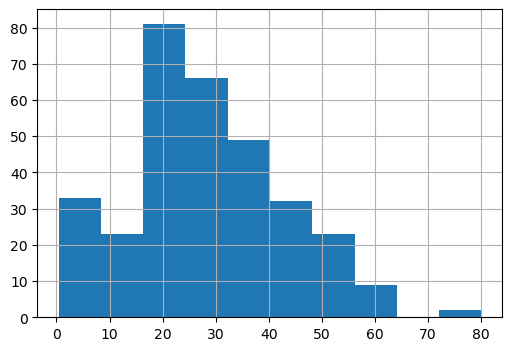

In [893]:
surv = data['age'][data['survived']==1]
not_surv = data['age'][data['survived']==0]
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()
 
ax.hist(surv)
ax.grid()

plt.show()

In [894]:
data

,pclass,survived,name,sex,age,fare,embarked,fam_size
0,3,1,"Smyth, Miss. Julia",female,NaN,7.7333,Q,0
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,7.7500,Q,0
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,7.2292,C,0
3,3,0,"Vovk, Mr. Janko",male,22.0,7.8958,S,0
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,9.5000,S,0
...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,8.0500,S,0
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,8.0500,S,0
978,2,0,"Gillespie, Mr. William Henry",male,34.0,13.0000,S,0
979,3,0,"Barton, Mr. David John",male,22.0,8.0500,S,0


# Модель на основе числовых признаков

## Удаление строк с пропусками

В качестве базовой модели имеет смысл построить модель с минимальными трудозатратами.

Из исходного датасета удалите все категориальные признаки, а также строки, содержащие пропуски.

При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки<b> с параметрами, указанными в вашем задании</b>. Используйте стратификацию по колонке <code>survived</code>.

Обучите модель <code>LogisticRegression()</code> <b>с параметрами, указанными в вашем задании</b>, на тренировочных данных, оцените на тестовых.

Вычислите <code>f1_score</code> модели на тестовых данных (рекомендуем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">соответствующую функцию</a> с параметрами по умолчанию.



In [895]:
data_int = data.loc[:, data.dtypes != 'object']
data_int = data_int.dropna()
data_int

,pclass,survived,age,fare,fam_size
2,3,1,38.0,7.2292,0
3,3,0,22.0,7.8958,0
4,3,0,16.0,9.5000,0
5,3,1,29.0,7.7500,0
7,1,0,25.0,26.0000,0
...,...,...,...,...,...
975,2,0,19.0,10.5000,0
977,3,1,19.0,8.0500,0
978,2,0,34.0,13.0000,0
979,3,0,22.0,8.0500,0


In [896]:
X = data_int.drop(columns='survived')
y = data_int['survived']

In [897]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

In [898]:
model = LogisticRegression(random_state=7, max_iter=1000)
model.fit(X_train, y_train)
pred = model.predict(X_test)
f1_score(y_test, pred)

0.5283018867924528

## Заполнение пропусков средним

Качество полученной модели оставляет желать лучшего. Имеет смысл попробовать заполнить пропуски. Из исходного набора данных удалите категориальные признаки, а пропуски заполните средним по столбцу. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [899]:
data_int = data.loc[:, data.dtypes != 'object']
data_int = data_int.fillna(data_int.mean())

In [900]:
X = data_int.drop(columns='survived')
y = data_int['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

model = LogisticRegression(random_state=7, max_iter=1000)
model.fit(X_train, y_train)
pred = model.predict(X_test)
f1_score(y_test, pred)

0.46428571428571436

## Заполнение пропусков на основе обращения


Очевидно, что заполнение пропусков в колонке <code>age</code> средним — не самая разумная идея. Возможно, стоит выполнить эту процедуру как-то более интеллектуально, например, с оглядкой на обращение к человеку. 

Можно заметить, что исходный датасет в столбце <code>name</code> содержит информацию о социальном статусе пассажира, а именно присутсвуют обращения <code>Mr., Mrs., Dr.</code> и т.д. На основе этой информации можно попробовать сделать предположение о возрасте пассажира.

Верните в рассмотрение колонку <code>name</code>. Создайте отдельную колонку <code>honorific</code> и поместите туда значения обращений.

Вычислите число уникальных обращений.

In [901]:
data_names = data.loc[:, data.dtypes != 'object']
data_names['name'] = data['name']
data_names

C:\Users\eugen\AppData\Local\Temp\ipykernel_7388\982115235.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_names['name'] = data['name']


,pclass,survived,age,fare,fam_size,name
0,3,1,NaN,7.7333,0,"Smyth, Miss. Julia"
1,3,1,NaN,7.7500,0,"Glynn, Miss. Mary Agatha"
2,3,1,38.0,7.2292,0,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)"
3,3,0,22.0,7.8958,0,"Vovk, Mr. Janko"
4,3,0,16.0,9.5000,0,"de Pelsmaeker, Mr. Alfons"
...,...,...,...,...,...,...
976,3,1,NaN,8.0500,0,"Howard, Miss. May Elizabeth"
977,3,1,19.0,8.0500,0,"Dorking, Mr. Edward Arthur"
978,2,0,34.0,13.0000,0,"Gillespie, Mr. William Henry"
979,3,0,22.0,8.0500,0,"Barton, Mr. David John"


In [902]:
data_names.head(12)

,pclass,survived,age,fare,fam_size,name
0,3,1,NaN,7.7333,0,"Smyth, Miss. Julia"
1,3,1,NaN,7.7500,0,"Glynn, Miss. Mary Agatha"
2,3,1,38.0,7.2292,0,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)"
3,3,0,22.0,7.8958,0,"Vovk, Mr. Janko"
4,3,0,16.0,9.5000,0,"de Pelsmaeker, Mr. Alfons"
5,3,1,29.0,7.7500,0,"Daly, Mr. Eugene Patrick"
6,3,0,NaN,7.2500,0,"Wiseman, Mr. Phillippe"
7,1,0,25.0,26.0000,0,"Birnbaum, Mr. Jakob"
8,3,0,27.0,7.8958,0,"Danoff, Mr. Yoto"
9,3,0,13.0,31.3875,6,"Asplund, Master. Filip Oscar"


In [903]:
# data_names['name'].loc[2][data_names['name'].loc[2].find(',')+2:data_names['name'].loc[2].find('.')]

In [904]:
list_honorific = []
for i in data['name']:
	fw = i.index(',')
	lw = i.index('.')
	list_honorific.append(i[fw+2:lw])

In [905]:
data_names['honorific'] = list_honorific

C:\Users\eugen\AppData\Local\Temp\ipykernel_7388\1959923749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_names['honorific'] = list_honorific


In [906]:
len(data_names['honorific'].value_counts())

14

In [907]:
data_names['honorific'].value_counts()

Mr              572
Miss            194
Mrs             145
Master           46
Rev               6
Dr                6
Col               3
Mlle              2
Ms                2
Dona              1
the Countess      1
Major             1
Don               1
Capt              1
Name: honorific, dtype: int64

Скорее всего имеет смысл сократить число обращений, добавив малочисленные группы к более многочисленным, так как принципиальной разницы между, например, <code>Don</code> и <code>Mr</code>, видимо, нет. Отметим, что <code>Master</code> — это прежнее обращение к ребенку, с этим обращением будем работать отдельно.




Выполните следующие замены:

<code>Mr</code> $\leftarrow$ <code>['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt']</code>

<code>Mrs</code> $\leftarrow$ <code> ['Dona', 'Countess']</code>

<code>Miss</code> $\leftarrow$ <code> ['Mlle', 'Ms']</code>

In [908]:
Mr = ['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt']
Mrs = ['Dona', 'Countess', 'the Countess']
Miss = ['Mlle', 'Ms']

In [909]:
data_names.replace({'honorific': Mr}, 'Mr', inplace=True)
data_names.replace({'honorific': Mrs}, 'Mrs', inplace=True)
data_names.replace({'honorific': Miss}, 'Miss', inplace=True)
data_names['honorific'].value_counts()

C:\Users\eugen\AppData\Local\Temp\ipykernel_7388\2541666871.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_names.replace({'honorific': Mr}, 'Mr', inplace=True)
C:\Users\eugen\AppData\Local\Temp\ipykernel_7388\2541666871.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_names.replace({'honorific': Mrs}, 'Mrs', inplace=True)
C:\Users\eugen\AppData\Local\Temp\ipykernel_7388\2541666871.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

Mr        590
Miss      198
Mrs       147
Master     46
Name: honorific, dtype: int64

Вычислите долю строк со значением <code>Master</code> относительно числа всех мужчин

In [910]:
len_master = len(data_names[data_names['honorific'] == 'Master'])
len_mr = len(data_names[data_names['honorific'] == 'Mr'])

In [911]:
len_master / (len_master + len_mr) # 46/46+590

0.07232704402515723

Вычислите средний возраст категории, указанной в вашем индивидуальном задании

In [912]:
data_names[data_names.honorific == 'Miss'].age.mean()

22.00576540880503

In [913]:
data_names.isna().sum()

pclass         0
survived       0
age          199
fare           0
fam_size       0
name           0
honorific      0
dtype: int64

Заполните пропуски в колонке <code>age</code> средним, соответствующим среднему категории <code>honorific</code>.

Избавьтесь от нечисловых признаков. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [914]:
data_names[data_names.honorific == 'Mr'] = data_names[data_names.honorific == 'Mr'].fillna(data_names[data_names.honorific == 'Mr'].age.mean())
data_names[data_names.honorific == 'Miss'] = data_names[data_names.honorific == 'Miss'].fillna(data_names[data_names.honorific == 'Miss'].age.mean())
data_names[data_names.honorific == 'Mrs'] = data_names[data_names.honorific == 'Mrs'].fillna(data_names[data_names.honorific == 'Mrs'].age.mean())
data_names[data_names.honorific == 'Master'] = data_names[data_names.honorific == 'Master'].fillna(data_names[data_names.honorific == 'Master'].age.mean())

C:\Users\eugen\AppData\Local\Temp\ipykernel_7388\3897746397.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_names[data_names.honorific == 'Mr'] = data_names[data_names.honorific == 'Mr'].fillna(data_names[data_names.honorific == 'Mr'].age.mean())
C:\Users\eugen\AppData\Local\Temp\ipykernel_7388\3897746397.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_names[data_names.honorific == 'Miss'] = data_names[data_names.honorific == 'Miss'].fillna(data_names[data_names.honorific == 'Miss'].age.me

In [915]:
data_new = data_names
data_new = data_new.loc[:, data_new.dtypes != 'object']
data_new

,pclass,survived,age,fare,fam_size
0,3,1,22.005765,7.7333,0
1,3,1,22.005765,7.7500,0
2,3,1,38.000000,7.2292,0
3,3,0,22.000000,7.8958,0
4,3,0,16.000000,9.5000,0
...,...,...,...,...,...
976,3,1,22.005765,8.0500,0
977,3,1,19.000000,8.0500,0
978,2,0,34.000000,13.0000,0
979,3,0,22.000000,8.0500,0


In [916]:
X = data_new.drop(columns='survived')
y = data_new['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

model.fit(X_train, y_train)
pred = model.predict(X_test)
f1_score(y_test, pred)

0.46428571428571436

# Модель с использование категориальных признаков

В исходном наборе данных заполните пропуски колонки <code>age</code> значениями на основе обращений (как в предыдущем пункте).

Не используйте признаки <code>name</code> и <code>honorific</code>. Они свою функцию выполнили.

Произведите <code>one-hot</code> кодировние нечисловых признаков, например, с помощью <code>pd.get_dummies(drop_first=True)</code>. Далее по знакомой схеме: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [917]:
data

,pclass,survived,name,sex,age,fare,embarked,fam_size
0,3,1,"Smyth, Miss. Julia",female,NaN,7.7333,Q,0
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,7.7500,Q,0
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,7.2292,C,0
3,3,0,"Vovk, Mr. Janko",male,22.0,7.8958,S,0
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,9.5000,S,0
...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,8.0500,S,0
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,8.0500,S,0
978,2,0,"Gillespie, Mr. William Henry",male,34.0,13.0000,S,0
979,3,0,"Barton, Mr. David John",male,22.0,8.0500,S,0


In [918]:
data = data.drop(columns='name')
data.age = data_names.age

In [2]:
data

NameError: name 'data' is not defined

In [ ]:
data = pd.get_dummies(data, drop_first=True)

In [923]:
X = data.drop(columns='survived')
y = data['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

model.fit(X_train, y_train)
pred = model.predict(X_test)
f1_score(y_test, pred)

0.5777777777777778